Visualization, summer term 2024 \
\
Problem sheet 06

Submission by: 

Engel, Laurenz (21962216) \
Hesenkamp, Dennis (16442976) \
Multhaup, Justus (21963889)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy

# Exercise 6.1: Dimensionality reduction on histograms

In [2]:
file = np.load('hist.npz')
file["data"].shape

# every datapoint is a histogram of dimension 25
# the question now if the intrinsic dimension is less than that

# Extract the keys
labels = file['labels']
binspec = file['binspec']
data = file['data']

# split data by label
data0 = data[labels==0]
data1 = data[labels==1]

# get middle of bins
bin_mid = (binspec[:-1] + binspec[1:]) / 2

# get normalization constant of data
norm = np.empty(0)
for hist in data:
    norm = np.append(norm,np.trapz(hist, bin_mid))
# compute average
norm = np.mean(norm)

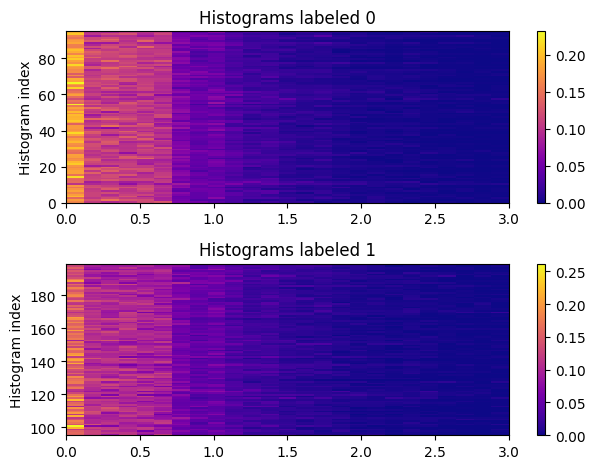

In [3]:
fig, axs = plt.subplots(2)
axs[0].set_title("Histograms labeled 0")
axs[1].set_title("Histograms labeled 1")
axs[0].set_ylabel("Histogram index")
axs[1].set_ylabel("Histogram index")

# plot histograms separately for different labels
p1 = axs[0].pcolormesh(binspec, np.arange(0,data0.shape[0]+1, 1), data0, cmap="plasma", rasterized=True)
p2 = axs[1].pcolormesh(binspec, np.arange(0,data1.shape[0]+1, 1) + data0.shape[0], data1, cmap="plasma", rasterized=True)
fig.colorbar(p1, ax=axs[0])
fig.colorbar(p2, ax=axs[1])
plt.tight_layout()


There is no obvious difference between the different labels.

In [4]:
# take PCA function from the lecture
def PCA(dataMat,keep=None,centered=False):
    nSamples,dim=dataMat.shape
    # centerted True, then data is already centered
    if not centered:
        mean=np.mean(dataMat,axis=0)
        dataMat=dataMat.copy()
        dataMat=dataMat-mean
    if dim<nSamples:
        if keep is None:
            keep=dim
        A=dataMat.transpose().dot(dataMat)/nSamples
        eigData=np.linalg.eigh(A)
        eigval=(eigData[0][-keep::])[::-1]
        eigvec=((eigData[1][:,-keep::]).transpose())[::-1]
    else:
        if keep is None:
            keep=nSamples
        A=dataMat.dot(dataMat.transpose())/nSamples
        eigData=np.linalg.eigh(A)
        eigval=(eigData[0][-keep::])[::-1]
        eigvec=((eigData[1][:,-keep::]).transpose())[::-1]

        eigvec=np.einsum(eigvec,[0,1],dataMat,[1,2],[0,2])
        # renormalize
        normList=np.linalg.norm(eigvec,axis=1)
        eigvec=np.einsum(eigvec,[0,1],1/normList,[0],[0,1])
    if not centered:
        return mean,eigval,eigvec
    else:
        return eigval,eigvec

In [5]:
mean,eigval,eigvec=PCA(data)

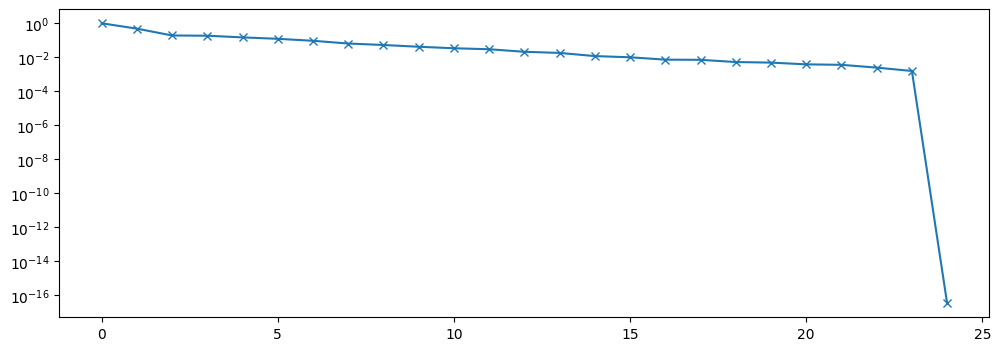

In [6]:
fig=plt.figure(figsize=(12,4))
ax=fig.subplots(1)
ax.plot(eigval/eigval[0],marker="x")
ax.set_yscale("log")

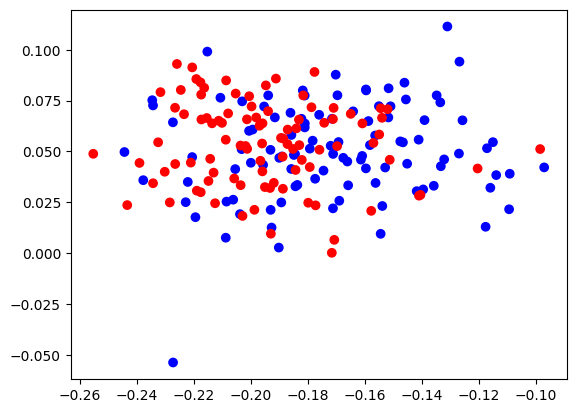

In [7]:
# project data onto first two eigenvectors
v1 = data @ eigvec[0]
v2 = data @ eigvec[1]

# Define custom colors
color_map = {0: 'red', 1: 'blue'}
colors = [color_map[label] for label in labels]
plt.scatter(v1, v2, c=colors)

The two classes do not appear to be different.

In [8]:
# try invcumul
def transformToInvCumul(mass,pos,nsample=500):
    massCum = np.concatenate((np.array([0.]), np.cumsum(mass)))
    posHat = np.concatenate((pos[[0]], pos))
    f = scipy.interpolate.interp1d(massCum, posHat, kind="next", assume_sorted=True)
    return f(np.linspace(0, 1, num=nsample, endpoint=False))

def transformFromInvCumul(cumul,bins):
    return np.histogram(cumul,bins=bins,density=True)[0]


data_invcumul=np.array([transformToInvCumul(x,binspec[:-1]) for x in data])
mean2,eigval2,eigvec2=PCA(data_invcumul)

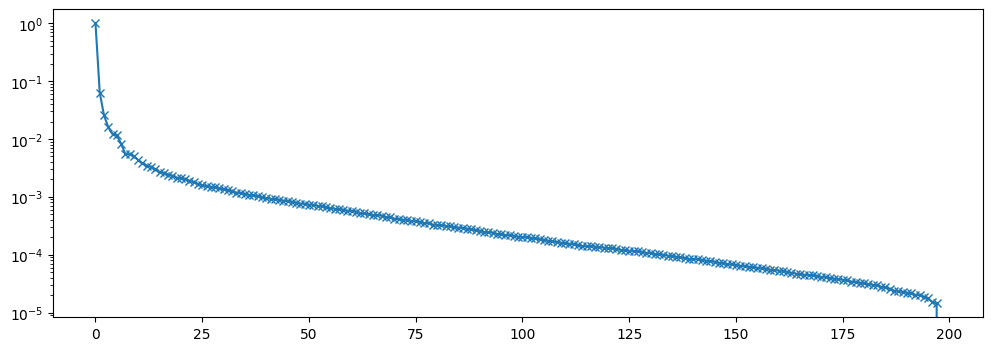

In [9]:
fig=plt.figure(figsize=(12,4))
ax=fig.subplots(1)
ax.plot(eigval2/eigval2[0],marker="x")
ax.set_yscale("log")

The spectrum is now decreasing much faster

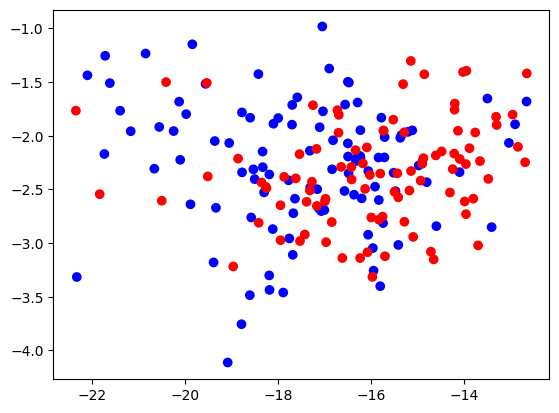

In [10]:
# project data onto first two eigenvectors
v21 = data_invcumul @ eigvec2[0]
v22 = data_invcumul @ eigvec2[1]
plt.scatter(v21, v22, c=colors)

The classes are still not linearly separable.

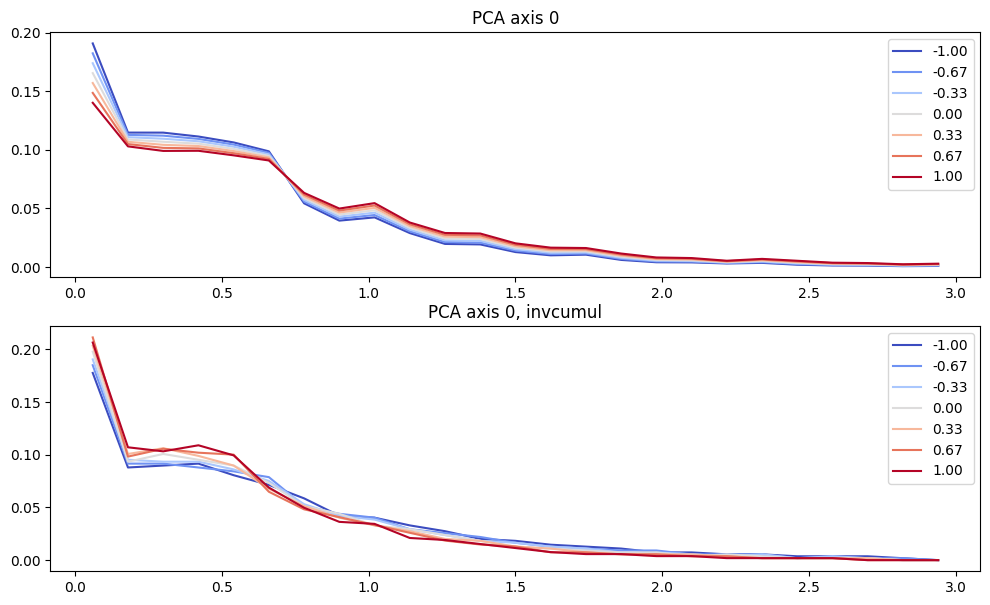

In [11]:
# define array for traversal along PCA direction
vals=np.linspace(-1,1,num=7)


fig=plt.figure(figsize=(12,7))
axs=fig.subplots(2)


data_reverse=mean+(eigval[0]**0.5)*vals.reshape((-1,1))*eigvec[0].reshape((1,-1))
for val,h in zip(vals,data_reverse):
    axs[0].plot(bin_mid,h,c=matplotlib.cm.coolwarm((val+1)/2), label=f"{val:.2f}")
axs[0].set_title(f"PCA axis {0}")
axs[0].legend()


data_reverse=mean2+(eigval2[0]**0.5)*vals.reshape((-1,1))*eigvec2[0].reshape((1,-1))
# remember to multiply by norm
data_reverse=[transformFromInvCumul(cumul,binspec) * norm for cumul in data_reverse] 
for val,h in zip(vals,data_reverse):
    axs[1].plot(bin_mid,h,c=matplotlib.cm.coolwarm((val+1)/2), label=f"{val:.2f}")
axs[1].set_title(f"PCA axis {0}, invcumul")
axs[1].legend()
plt.show()

As expected, the histograms do not vary much along the first PCA axis for both the original data and the cumulative distance transformed data. For the invcumul data, the variation is exactly inverse to the variation of the original data. 

# Exercise 6.2: nonlinear manifold learning with UMAP

In [12]:
import glob
import re
import imageio
import umap


/Users/justusmulthaup/Desktop/visualization_homework/visualization-homework/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
img_paths = glob.glob("imgs/*png")
elevation = np.empty(0)
azimuth = np.empty(0)
data = []
# blurred data for later
kernel = np.array([[1/16, 1/8, 1/16],
              [1/8, 1/4, 1/8],
              [1/16, 1/8, 1/16]]) 
data_blurred = []
for path in img_paths:
    # search for _e<number>_ and _a<number>. patterns
    match_e = re.search(r'_e(\d+)_', path)
    match_a = re.search(r'_a(\d+)\.', path)
    elevation = np.append(elevation, int(match_e.group(1)))
    azimuth = np.append(azimuth, int(match_a.group(1)))
    img = imageio.imread(path)
    data.append(img)
    data_blurred.append(scipy.signal.convolve2d(img, kernel, mode="valid"))
# convert data to numpy array
data = np.array(data)
data_blurred = np.array(data_blurred)
# flatten along 2nd and 3rd axis
data_flattened = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
data_blurred_flattened = data_blurred.reshape(data_blurred.shape[0], data_blurred.shape[1] * data_blurred.shape[2])

/var/folders/f5/zmpl7j_93n5bz1wd70hgb4140000gn/T/ipykernel_23757/769758142.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(path)


In [20]:
reducer = umap.UMAP(n_components=2)
emb=reducer.fit_transform(data_flattened)

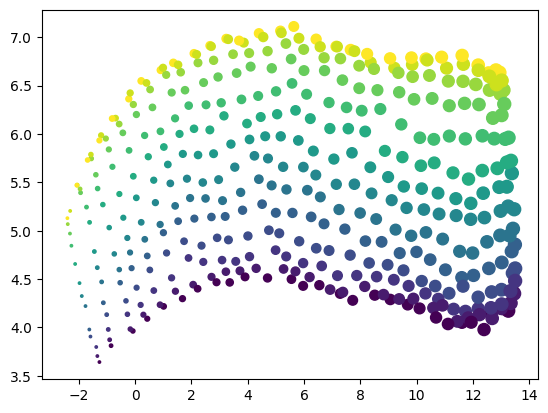

In [26]:
plt.scatter(emb[:,0], emb[:,1], c=elevation, s=azimuth)

UMAP convers the underlying manifold pretty well. The x axis seems to capture the variation of the azimuth angle while the y axis captures the variation of the elevation. 

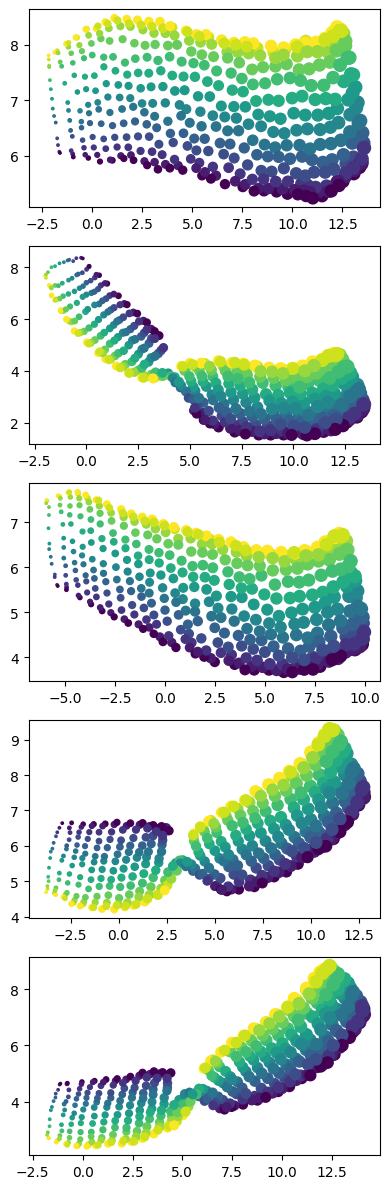

In [29]:
n_runs = 5
fig, axs = plt.subplots(n_runs, figsize=(4, 12))
for ax in axs:
    reducer = umap.UMAP(n_components=2)
    emb=reducer.fit_transform(data_flattened)
    ax.scatter(emb[:,0], emb[:,1], c=elevation, s=azimuth)
plt.tight_layout()
plt.show()

There seems to be some funky stuff going on. At certain angles UMAP tends to flip the elevation coordinate.

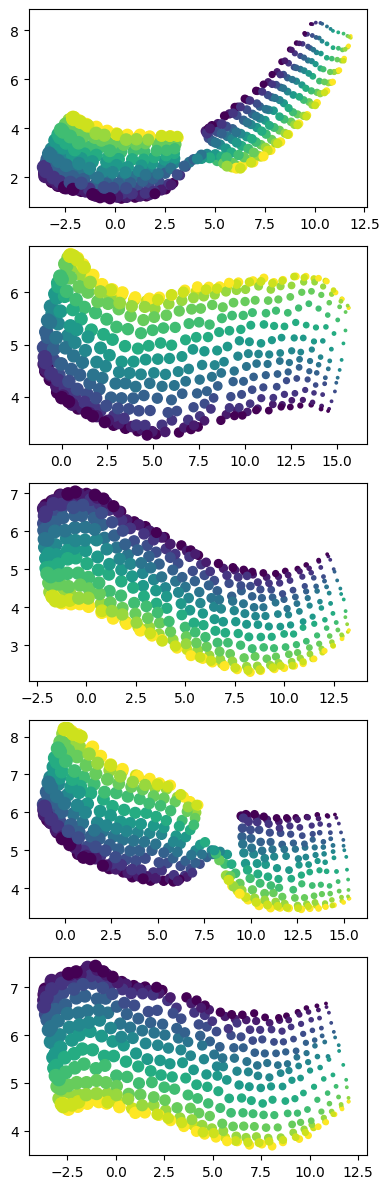

In [32]:
# repeat for blurred data
n_runs = 5
fig, axs = plt.subplots(n_runs, figsize=(4, 12))
for ax in axs:
    reducer = umap.UMAP(n_components=2)
    emb=reducer.fit_transform(data_blurred_flattened)
    ax.scatter(emb[:,0], emb[:,1], c=elevation, s=azimuth)
plt.tight_layout()
plt.show()

The direction of variation of the x axis is now flipped. The instability still happens, the results did not improve.